# The ns-3 network simulator

ns-3 is a discrete-event network simulator for Internet systems, targeted primarily for research and educational use. ns-3 is free, open-source software, licensed under the GNU GPLv2 license, and maintained by a worldwide community.

## Getting the ns-3 python bindings

The ns-3 modules are written in C++, but Python can be used to write simulations and models via the ns-3 python bindings.

You can install a prepackaged version of ns-3 via the `pip install ns3` command, if you are using CPython on Linux.

If you are running ns-3 on a Jupyter notebook, you should be able to install the prepackaged ns-3 via the same command preceded by an exclamation point `!pip install ns3`. This works on online notebooks, such as [Google Collab](https://colab.research.google.com/).

Uncomment the lines below and run its contents to install ns-3 via a jupyter notebook.

In [1]:
#!pip install ns3

If you can't use the prepackaged version or want to use a manual setup to be able to modify upstream modules, then setup ns-3 manually after building ns-3 with python bindings enabled (`./ns3 configure --enable-python-bindings && ./ns3 build`).

Uncomment the lines below and run its contents to manually load the ns-3 installation.

In [31]:
## You must run jupyter from the ns-3-dev directory,
## or adjust these paths to the absolute directory path of ns-3-dev
#import sys
#sys.path.append("./ns-3-dev/build/bindings/python")
#sys.path.append("./ns-3-dev/build/lib")

## The ns-3 basics

In the following sections, we review how ns-3 works. First, import ns3.

In [3]:
from ns import ns

[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-148, _ZN3ns3L16g_timeInitHelperE, $.cling-module-148.__inits.0, _GLOBAL__sub_I_cling_module_148, __cxx_global_var_initcling_module_148_ }) }
[runStaticInitializersOnce]: Failed to materialize symbols: { (main, { __orc_init_func.cling-module-148 }) }


### Discrete-event simulators

ns-3 is a discrete-event simulator. This means the time of the simulation passes when events are processed, instead of being real time. Let us see an example of such thing.

In [4]:
# To make sure we can rerun this cell cleanly, clear the simulator state
ns.Simulator.Destroy()

# Here we define a callback function that will fetch the Simulator time and convert it to seconds
def printCurrentTime() -> None:
    print(f"Current time: {ns.Simulator.Now().GetSeconds()}s")

# The bindings are not perfect and require this workaround to transform
# the Python function into an EventImpl* that can be scheduled
ns.cppyy.cppdef("""
// Defining the following function as part of the ns3 namespace
// allows it to be accessed later via ns.printCurrentTimeMakeEvent().
// If the namespace is not specified, it will be accessable via
// ns.cppyy.gbl.printCurrentTimeMakeEvent().
namespace ns3
{
    EventImpl* printCurrentTimeMakeEvent(void (*f)())
    {
        return MakeEvent(f);
    }
}
""")

for i in range(1, 10):
    event = ns.printCurrentTimeMakeEvent(printCurrentTime)
    eventId = ns.Simulator.Schedule(ns.Seconds(i), event)
    print(eventId)

We should see a list of event IDs, indicating we successfully scheduled the `printCurrentTime()` function to run at every second of the simulation (`ns.Simulator.Schedule(ns.Seconds(i), event)`).

But the simulation will not be executed with just that.

### Starting and stopping a simulation

Before starting a simulation, remember to setup a time limit to it, otherwise it can end up running indefinitely due to events rescheduling themselves. This can be done via the following command.

In [5]:
ns.Simulator.Stop(ns.Seconds(10)) # Make the simulator stop at 10 virtual seconds

Now we can safely start the simulator.

When the simulator is started, it will start fetching scheduled events executing in chronologic order.

In [6]:
ns.Simulator.Run()

Current time: 1.0s
Current time: 2.0s
Current time: 3.0s
Current time: 4.0s
Current time: 5.0s
Current time: 6.0s
Current time: 7.0s
Current time: 8.0s
Current time: 9.0s


We should now see a list of printed time by each of the scheduled events.

Now that our simulation finished, we must clean the simulator state before running a different simulation.

del event
del eventId
ns.Simulator.Destroy()

### Scheduling events for the current time: ScheduleNow

To continue processing unrelated code-paths, `ScheduleNow` can get used to schedule events for the same time as the current simulator time. These events will be executed after all other events with the same chronological timestamp.

Let's check that by repeating the time printing events from above, but adding a different event that uses `ScheduleNow`.

In [7]:
def printCurrentTimeScheduleNow() -> None:
    print(f"ScheduleNow event:{ns.Simulator.Now().GetSeconds()}s")

def scheduleScheduleNow() -> None:
    print(f"Scheduling ScheduleNow event: {ns.Simulator.Now().GetSeconds()}s")
    event = ns.printCurrentTimeMakeEvent(printCurrentTimeScheduleNow)
    ns.Simulator.ScheduleNow(event)

# Scheduling the ScheduleNow event
event = ns.printCurrentTimeMakeEvent(scheduleScheduleNow)
ns.Simulator.Schedule(ns.Seconds(1), event)

# Scheduling other time printing events
event = ns.printCurrentTimeMakeEvent(printCurrentTime)
ns.Simulator.Schedule(ns.Seconds(1), event)
ns.Simulator.Schedule(ns.Seconds(1.5), event)
ns.Simulator.Schedule(ns.Seconds(2), event)

ns.Simulator.Stop(ns.Seconds(2))
ns.Simulator.Run()
del event
ns.Simulator.Destroy()

Scheduling ScheduleNow event: 11.0s
Current time: 11.0s
ScheduleNow event:11.0s
Current time: 11.5s
Current time: 12.0s


As it can be seen, the `ScheduleNow` event is executed at the exact same virtual time as the event that scheduled it.

### Self-scheduling events

The previous examples were very simple, but the infrastructure for event management, scheduling and execution allows for very large and complex systems to be modeled.

For example, we can model periodic checking of some kind by re-scheduling an event.

We can adapt the examples above to do the time printing without scheduling all events before starting the simulation.

In [8]:
# The bindings are not perfect and require this workaround to transform
# the Python function into an EventImpl*
ns.cppyy.cppdef("""
namespace ns3
{
    EventImpl* printCurrentTimePeriodicMakeEvent(void (*f)(ns3::Time&), ns3::Time period)
    {
        return MakeEvent(f, period);
    }
}
""")

def printCurrentTimePeriodic(period: ns.Time) -> None:
    print(f"Current time: {ns.Simulator.Now().GetSeconds()}s")
    event = ns.printCurrentTimePeriodicMakeEvent(printCurrentTimePeriodic, period)
    ns.Simulator.Schedule(period, event)

def periodicEventExample():
    # Create a periodic event that runs after every second
    event = ns.printCurrentTimePeriodicMakeEvent(printCurrentTimePeriodic, ns.Seconds(1))
    ns.Simulator.Schedule(ns.Seconds(1), event)

    # Set the simulation duration to 11 seconds
    ns.Simulator.Stop(ns.Seconds(11))
    ns.Simulator.Run()
    ns.Simulator.Destroy()

periodicEventExample()

Current time: 1.0s
Current time: 2.0s
Current time: 3.0s
Current time: 4.0s
Current time: 5.0s
Current time: 6.0s
Current time: 7.0s
Current time: 8.0s
Current time: 9.0s
Current time: 10.0s


As it can be seen, an initial scheduled event re-scheduled itself for every second of the simulation,
printing 10 times.

But we can also cancel events, allowing for the modelling of timeouts.

### Canceling events

When we work with timeouts, we need to keep track of time, and act in case a certain amount of time passes.

To model that, we can schedule a self-rescheduling timeout event that can be cancelled in case an action happens.

Let's see the code for that.

In [9]:
# The bindings are not perfect and require this workaround to transform
# the Python function into an EventImpl*
ns.cppyy.cppdef("""
    EventImpl* parameterlessMakeEvent(void (*f)())
    {
        return MakeEvent(f);
    }
""")

def watchdogEvent() -> None:
    print(f"Watchdog reporting a timeout at {ns.Simulator.Now().GetSeconds():.2f}s")

# The scheduled watchdog event Id that will get cancelled and rescheduled if it doesn't run out of time
watchdogEventId = None

def printCurrentTimeRandomPeriod() -> None:
    import random
    global watchdogEventId
    print(f"Current time: {ns.Simulator.Now().GetSeconds():.2f}s")

    # Cancel previous watchdog event and re-schedule it
    watchdogEventId.Cancel()
    watchdogEventImpl = ns.cppyy.gbl.parameterlessMakeEvent(watchdogEvent)
    watchdogEventId = ns.Simulator.Schedule(ns.MilliSeconds(800), watchdogEventImpl)

    # Re-schedule the current event with random periods (e.g. fluctuating latency)
    watchedEvent = ns.cppyy.gbl.parameterlessMakeEvent(printCurrentTimeRandomPeriod)
    ns.Simulator.Schedule(ns.Seconds(random.random()), watchedEvent)

Now we can run the simulation and observe the behavior of that watchdog and see if it really barks when the timeout time runs out (the event isn't cancelled before its scheduled execution time).

In [10]:
def watchdogExample():
    global watchdogEventId
    # Create watchdog event and schedule it with a timeout of 800 milliseconds
    watchdogEventImpl = ns.cppyy.gbl.parameterlessMakeEvent(watchdogEvent)
    watchdogEventId = ns.Simulator.Schedule(ns.MilliSeconds(800), watchdogEventImpl)

    # Create a periodic event that runs after every second
    watchedEvent = ns.cppyy.gbl.parameterlessMakeEvent(printCurrentTimeRandomPeriod)
    ns.Simulator.Schedule(ns.Seconds(0.5), watchedEvent)

    # Set the simulation duration to 11 seconds
    ns.Simulator.Stop(ns.Seconds(11))
    ns.Simulator.Run()
    ns.Simulator.Destroy()

watchdogExample()
del watchdogEventId

Current time: 0.50s
Current time: 1.13s
Current time: 1.83s
Current time: 2.45s
Current time: 3.00s
Current time: 3.62s
Current time: 4.14s
Current time: 4.73s
Current time: 5.20s
Current time: 5.75s
Current time: 6.31s
Current time: 6.59s
Current time: 6.90s
Current time: 7.43s
Current time: 8.00s
Current time: 8.74s
Current time: 8.95s
Current time: 9.07s
Current time: 9.48s
Watchdog reporting a timeout at 10.28s
Current time: 10.42s
Current time: 10.46s
Current time: 10.74s


There should be a few random timeouts in the output above. These could represent, for example, the timeouts observed in network connections.

## Network topologies

All networks are made up of nodes connected either physically via a cable of some sort, or wirelessly via sound, light or radio waves.

Let's build a very simple topology to demonstrate how it works.

First we need network nodes.

In [11]:
nodes = ns.NodeContainer()
nodes.Create(10) # Create 10 nodes

Now that we have nodes, we need to distribute them over the space. This can be done using mobility models.

We can make them static using the `ConstantPositionMobilityModel`. And we can set their coordinates with the help of a `PositionAllocation`. In our case, we will be using the `ListPositionAllocator`, where we create a list of coordinates that will be then assigned to a `NodeContainer`.

In [12]:
linePositions = ns.CreateObject[ns.ListPositionAllocator]()
for line in range(2):
    for column in range(5):
        linePositions.__deref__().Add (ns.Vector(100*column, 100*line, 0))

mobilityHelper = ns.MobilityHelper()
mobilityHelper.SetMobilityModel ("ns3::ConstantPositionMobilityModel")
mobilityHelper.SetPositionAllocator (linePositions)
mobilityHelper.Install (nodes)

Not being able to see what we are doing sucks, so let us plot our current topology with the help of matplotlib.

In [13]:
from matplotlib import pyplot as plt

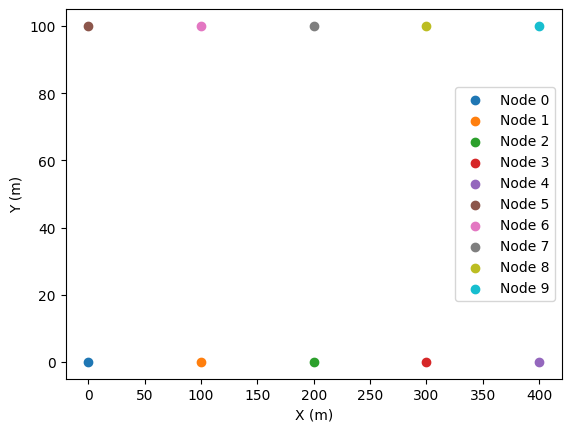

In [14]:
for node_i in range(nodes.GetN()):
    node = nodes.Get(node_i).__deref__()
    mobility = node.GetObject[ns.MobilityModel]().__deref__()
    position = mobility.GetPosition()
    plt.scatter((position.x), (position.y), label=f"Node {node.GetId()}")
plt.ylabel("Y (m)")
plt.xlabel("X (m)")
plt.legend()
plt.show()

Now that we can see where our nodes are, let's connect them via physical CSMA links.

In [15]:
csma = ns.CsmaHelper()
csmaDevices = csma.Install(nodes)

Next, plot the topology again, but now showing the links.

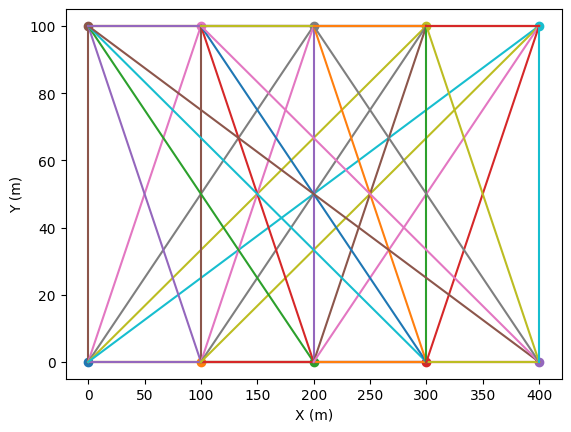

In [16]:
nodeIdToCoordinate = {}
channelIdToNodeIds = {}
for node_i in range(nodes.GetN()):
    node = nodes.Get(node_i).__deref__()
    nodeId = node.GetId()
    mobility = node.GetObject[ns.MobilityModel]().__deref__()
    position = mobility.GetPosition()
    nodeIdToCoordinate[nodeId] = (position.x, position.y)
    for device_i in range(node.GetNDevices()):
        netdevice = node.GetDevice(device_i).__deref__()
        if hasattr(netdevice, "GetChannel"):
            channel = netdevice.GetChannel().__deref__()
            channelId = channel.GetId()
            if channelId not in channelIdToNodeIds:
                channelIdToNodeIds[channelId] = []
            channelIdToNodeIds[channelId].append(nodeId)
    plt.scatter((position.x), (position.y), label=f"Node {node.GetId()}")

for (channelId, channelNodes) in channelIdToNodeIds.items():
    for i in range(len(channelNodes)):
        for j in range(i, len(channelNodes)):
            node_i = nodeIdToCoordinate[channelNodes[i]]
            node_j = nodeIdToCoordinate[channelNodes[j]]
            plt.plot([node_i[0], node_j[0]], [node_i[1], node_j[1]], label=f"Channel {channelId}")
plt.ylabel("Y (m)")
plt.xlabel("X (m)")
plt.show()

In [17]:
ns.Simulator.Destroy() # clear the simulator state for the next section

Since CSMA is a bus-protocol, all the nodes in the container passed to the CSMA helper will be linked together through the same bus (here shown as edges linking the different vertices).

## Traces and Callbacks

Now that we know how to schedule events, we can also make use of other ns-3 facilities known as `traces`.

Traces are hooks spread throughout the codebase which permit `callbacks` (function pointers/referenes) to be registered and called.

These can be used in a simulation to react or simply keep track of events happening in a simulation.

Let's see one example of `traces` and `callback` usage.

First we need a network topology to work with.

In [18]:
# Create two nodes
csmaNodes = ns.NodeContainer()
csmaNodes.Create(2)

# Create a CSMA helper to install the network interfaces and connect them via a physical link
csma = ns.CsmaHelper()
csma.SetChannelAttribute("DataRate", ns.StringValue("100Mbps"))
csma.SetChannelAttribute("Delay", ns.TimeValue(ns.NanoSeconds(6560)))

# Install the network interfaces and connect them via a physical link
csmaDevices = csma.Install(csmaNodes)

# Instal the TCP/IP network stack
stack = ns.InternetStackHelper()
stack.Install(csmaNodes)

# Create an address pool for the network nodes
address = ns.Ipv4AddressHelper()
address.SetBase(ns.Ipv4Address("10.1.2.0"), ns.Ipv4Mask("255.255.255.0"))

# Assign Ipv4 addresses to the network devices
csmaInterfaces = address.Assign(csmaDevices)

# Populate routing tables so that packages get properly routed
ns.Ipv4GlobalRoutingHelper.PopulateRoutingTables()

Now that we have a network, we can install applications that will make use of that network.

In [19]:
# Create, install and set the time the server application will run on the node 0
echoServer = ns.UdpEchoServerHelper(9)
serverApps = echoServer.Install(csmaNodes.Get(0))
serverApps.Start(ns.Seconds(1.0))
serverApps.Stop(ns.Seconds(10.0))

# Create, configure, install and set the time the client application will run on the node 1
echoClient = ns.UdpEchoClientHelper(csmaInterfaces.GetAddress(0).ConvertTo(), 9)
echoClient.SetAttribute("MaxPackets", ns.UintegerValue(10))
echoClient.SetAttribute("Interval", ns.TimeValue(ns.Seconds (1.0)))
echoClient.SetAttribute("PacketSize", ns.UintegerValue(1024))
clientApps = echoClient.Install(csmaNodes.Get(1))
clientApps.Start(ns.Seconds(2.0))
clientApps.Stop(ns.Seconds(10.0))

Now we have an application running on top of our network topology.

Now let's setup a `callback` function to tap into the `traces` from the server application.

In [20]:
# Cppyy bindings are not perfect and we need to create the callback via a Python-to-C++ wrapper
ns.cppyy.cppdef("""
    namespace ns3{
        const Callback<void,Ptr<const Packet>,const Address&,const Address&>
        make_sinktrace_callback(void(*func)(Ptr<const Packet>,const Address&,const Address&))
        {
            return MakeCallback(func);
        }
    }
""")

# We define our callback that will receive a packet smart-pointer and two addresses
def SinkTracer(packet: ns.Packet, src_address: ns.Address, dst_address: ns.Address) -> None:
    print(f"At {ns.Simulator.Now().GetSeconds():.0f}s, '{dst_address}' received packet"
          f" with {packet.__deref__().GetSerializedSize()} bytes from '{src_address}'")

# Create the callback calling the SinkTracer function defined above
sinkTraceCallback = ns.make_sinktrace_callback(SinkTracer)

# Register the callback to be called when the trace RxWithAddresses from UdpEchoServerHelper is executed
serverApps.Get(0).__deref__().TraceConnectWithoutContext("RxWithAddresses", sinkTraceCallback)

# Set the simulation duration to 11 seconds
ns.Simulator.Stop(ns.Seconds(11))

# Run the simulator
ns.Simulator.Run()
ns.Simulator.Destroy()

At 2s, '04-06-00:00:00:00:09:00' received packet with 60 bytes from '04-06-0a:01:02:02:01:c0'
At 3s, '04-06-00:00:00:00:09:00' received packet with 60 bytes from '04-06-0a:01:02:02:01:c0'
At 4s, '04-06-00:00:00:00:09:00' received packet with 60 bytes from '04-06-0a:01:02:02:01:c0'
At 5s, '04-06-00:00:00:00:09:00' received packet with 60 bytes from '04-06-0a:01:02:02:01:c0'
At 6s, '04-06-00:00:00:00:09:00' received packet with 60 bytes from '04-06-0a:01:02:02:01:c0'
At 7s, '04-06-00:00:00:00:09:00' received packet with 60 bytes from '04-06-0a:01:02:02:01:c0'
At 8s, '04-06-00:00:00:00:09:00' received packet with 60 bytes from '04-06-0a:01:02:02:01:c0'
At 9s, '04-06-00:00:00:00:09:00' received packet with 60 bytes from '04-06-0a:01:02:02:01:c0'


As it can be seen in the plotted results above, one packet is received every one second.

Each packet containing 60 bytes.

But a fixed-sized packet isn't super realistic. We can make that size change over time by scheduling events.

### Using events to change the size of packets sent over time

To change the packet sizes over time, we can pass the application reference to an event callback, which will change the application internal settings regularly. In the following case, we chose 1 second.

In [21]:
ns.cppyy.cppdef("""
    EventImpl* echoPacketSizeChangeMakeEvent(void (*f)(Ptr<UdpEchoClient>), Ptr<UdpEchoClient> cli)
    {
        return MakeEvent(f, cli);
    }
""")

import random

# Event that will reconfigure the application to change its data size from 100 and up to 4096 bytes per packet
def echoPacketSizeChangeEvent(echoClient: ns.UdpEchoClient) -> None:
    echoClient.__deref__().SetDataSize(random.randint(100, 4096))
    event = ns.cppyy.gbl.echoPacketSizeChangeMakeEvent(echoPacketSizeChangeEvent, echoClient)
    ns.Simulator.Schedule(ns.Seconds(1), event)
    
# Dictionary to keep track of received bytes over time
cumulative_bytes_address_pair = {}
def PlotSinkTracer(packet: ns.Packet, src_address: ns.Address, dst_address: ns.Address) -> None:
    global cumulative_bytes_address_pair
    src_ipv4 = ns.InetSocketAddress.ConvertFrom(src_address).GetIpv4().__str__()
    dst_ipv4 = ns.InetSocketAddress.ConvertFrom(dst_address).GetIpv4().__str__()
    if dst_ipv4 == "0.0.0.0":
        dst_ipv4 = "10.1.2.1" # Server listening on all ports
    key = (src_ipv4, dst_ipv4)
    # Create key with a pair of addresses. Could use ports too, to differentiate applications.
    if key not in cumulative_bytes_address_pair:
        cumulative_bytes_address_pair[key] = []
    # Store a tuple with time the packet was received and its size
    cumulative_bytes_address_pair[key].append((ns.Simulator.Now().GetNanoSeconds(), 
                                               packet.__deref__().GetSerializedSize())
                                             )

Next, we define define our simulation. This is basically the same scenario used above.

In [22]:
# Recreating the previous network topology
csmaNodes = ns.NodeContainer()
csmaNodes.Create(2)

csma = ns.CsmaHelper()
csma.SetChannelAttribute("DataRate", ns.StringValue("100Mbps"))
csma.SetChannelAttribute("Delay", ns.TimeValue(ns.NanoSeconds(6560)))
csmaDevices = csma.Install(csmaNodes)

stack = ns.InternetStackHelper()
stack.Install(csmaNodes)

address = ns.Ipv4AddressHelper()
address.SetBase(ns.Ipv4Address("10.1.2.0"), ns.Ipv4Mask("255.255.255.0"))
csmaInterfaces = address.Assign(csmaDevices)

echoServer = ns.UdpEchoServerHelper(9)
serverApps = echoServer.Install(csmaNodes.Get(0))
serverApps.Start(ns.Seconds(1.0))
serverApps.Stop(ns.Seconds(10.0))

echoClient = ns.UdpEchoClientHelper(csmaInterfaces.GetAddress(0).ConvertTo(), 9)
echoClient.SetAttribute("MaxPackets", ns.UintegerValue(10))
echoClient.SetAttribute("Interval", ns.TimeValue(ns.Seconds (1.0)))
echoClient.SetAttribute("PacketSize", ns.UintegerValue(1024))
clientApps = echoClient.Install(csmaNodes.Get(1))
clientApps.Start(ns.Seconds(2.0))
clientApps.Stop(ns.Seconds(10.0))

# Make the echo client package size change over time
udpEchoClient = clientApps.Get(0).GetObject[ns.UdpEchoClient]()
# Notice that echoPacketSizeChangeMakeEvent is prefixed with ns.cppyy.gbl. instead of ns. 
# because it wasn't declared inside the ns3 namespace in ns.cppyy.cppdef
event = ns.cppyy.gbl.echoPacketSizeChangeMakeEvent(echoPacketSizeChangeEvent, udpEchoClient)
ns.Simulator.Schedule(ns.Seconds(1), event)

ns.Ipv4GlobalRoutingHelper.PopulateRoutingTables()

# Connect the callback to the trace source
sinkTraceCallback = ns.make_sinktrace_callback(PlotSinkTracer)
serverApps.Get(0).__deref__().TraceConnectWithoutContext("RxWithAddresses", sinkTraceCallback);
clientApps.Get(0).__deref__().TraceConnectWithoutContext("RxWithAddresses", sinkTraceCallback);


# Set the simulation duration to 11 seconds
ns.Simulator.Stop(ns.Seconds(11))
ns.Simulator.Run()
ns.Simulator.Destroy()

Now our `cumulative_bytes_address_pair` will contain the history of received packet sizes.

In [23]:
print("Communicating pair:", list(cumulative_bytes_address_pair.keys())[0])

Communicating pair: ('10.1.2.2', '10.1.2.1')


Let's calculate the cumulative traffic and plot with matplotlib.

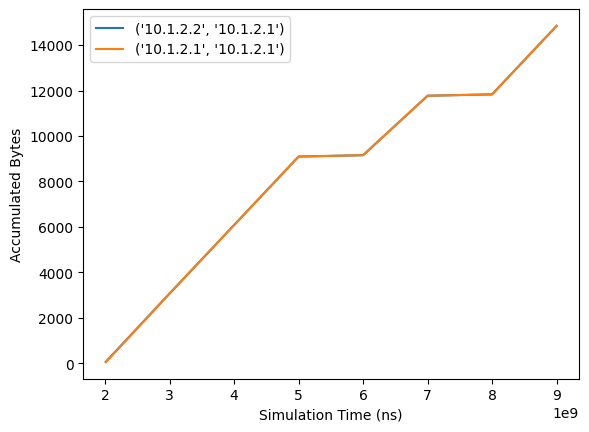

In [24]:
for pair in cumulative_bytes_address_pair:
    xs = []
    ys = []
    total_bytes = 0
    for (time_ns, size_bytes) in cumulative_bytes_address_pair[pair]:
        xs.append(time_ns)
        total_bytes += size_bytes
        ys.append(total_bytes)
    plt.plot(xs, ys, label=str(pair))
plt.ylabel("Accumulated Bytes")
plt.xlabel("Simulation Time (ns)")
plt.legend()
plt.show()

We can see that both ends have the same cumulative traffic. That is to be expected when using an echo application and a channel without loss.

Let's add some channel loss to see how things change.

### Channel loss

Some channel models are not as realistic as the `wireless` (WiFi/802.11) or the `lte` (4G/LTE) modules.

These modules can have a generic rate error model attached to them to cause some loss that would be expected in normal networks due to interference, attenuation, doppler effect, etc.

This can be achieved with the following setup, setting a 10% loss rate.

In [28]:
uv = ns.CreateObject[ns.UniformRandomVariable]()
em = ns.CreateObject[ns.RateErrorModel]()
em.__deref__().SetRandomVariable(uv.__deref__())
em.__deref__().SetAttribute("ErrorRate", ns.DoubleValue(0.1))
em.__deref__().SetAttribute("ErrorUnit", ns.StringValue("ERROR_UNIT_PACKET"))

Next, we recreate the previous scenario, but now attach that error model to our channel model.

In [29]:
# Reset packet size history
cumulative_bytes_address_pair = {}

# Recreating the previous network topology
csmaNodes = ns.NodeContainer()
csmaNodes.Create(2)

csma = ns.CsmaHelper()
csma.SetChannelAttribute("DataRate", ns.StringValue("100Mbps"))
csma.SetChannelAttribute("Delay", ns.TimeValue(ns.NanoSeconds(6560)))
# Add some loss to the network interfaces
# To discover the attribute names and value types, search in the .cc files that define them
csma.SetDeviceAttribute("ReceiveErrorModel", ns.PointerValue(em)); 
csmaDevices = csma.Install(csmaNodes)

stack = ns.InternetStackHelper()
stack.Install(csmaNodes)

address = ns.Ipv4AddressHelper()
address.SetBase(ns.Ipv4Address("10.1.2.0"), ns.Ipv4Mask("255.255.255.0"))
csmaInterfaces = address.Assign(csmaDevices)

echoServer = ns.UdpEchoServerHelper(9)
serverApps = echoServer.Install(csmaNodes.Get(0))
serverApps.Start(ns.Seconds(1.0))
serverApps.Stop(ns.Seconds(10.0))

echoClient = ns.UdpEchoClientHelper(csmaInterfaces.GetAddress(0).ConvertTo(), 9)
echoClient.SetAttribute("MaxPackets", ns.UintegerValue(10))
echoClient.SetAttribute("Interval", ns.TimeValue(ns.Seconds (1.0)))
echoClient.SetAttribute("PacketSize", ns.UintegerValue(1024))
clientApps = echoClient.Install(csmaNodes.Get(1))
clientApps.Start(ns.Seconds(2.0))
clientApps.Stop(ns.Seconds(10.0))

# Make the echo client package size change over time
udpEchoClient = clientApps.Get(0).GetObject[ns.UdpEchoClient]()
# Notice that echoPacketSizeChangeMakeEvent is prefixed with ns.cppyy.gbl. instead of ns. 
# because it wasn't declared inside the ns3 namespace in ns.cppyy.cppdef
event = ns.cppyy.gbl.echoPacketSizeChangeMakeEvent(echoPacketSizeChangeEvent, udpEchoClient)
ns.Simulator.Schedule(ns.Seconds(1), event)

ns.Ipv4GlobalRoutingHelper.PopulateRoutingTables()

# Connect the callback to the trace source
sinkTraceCallback = ns.make_sinktrace_callback(PlotSinkTracer)
serverApps.Get(0).__deref__().TraceConnectWithoutContext("RxWithAddresses", sinkTraceCallback);
clientApps.Get(0).__deref__().TraceConnectWithoutContext("RxWithAddresses", sinkTraceCallback);

# Set the simulation duration to 11 seconds
ns.Simulator.Stop(ns.Seconds(11))
ns.Simulator.Run()
ns.Simulator.Destroy()

We can finally print our cumulative bytes again. We should see a different in the plotted lines.

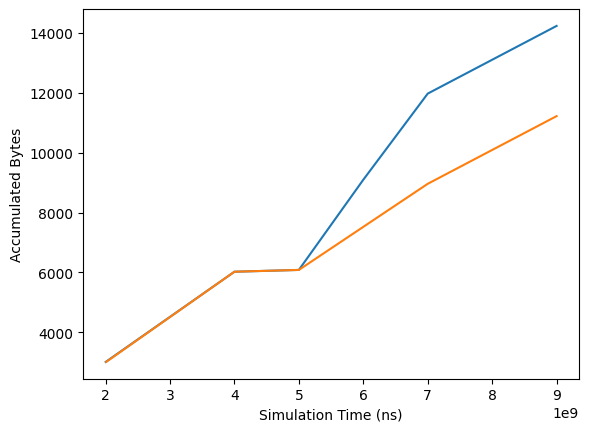

In [30]:
for pair in cumulative_bytes_address_pair:
    xs = []
    ys = []
    total_bytes = 0
    for (time_ns, size_bytes) in cumulative_bytes_address_pair[pair]:
        xs.append(time_ns)
        total_bytes += size_bytes
        ys.append(total_bytes)
    plt.plot(xs, ys, label=str(pair))
plt.ylabel("Accumulated Bytes")
plt.xlabel("Simulation Time (ns)")
plt.show()

## The end

If you have reached this, you should know the basics of ns-3 and how to setup a simple generic simulation.